## Sprint1 Alexander Chen

### Central question:
Can the data provided predict either:

1.	Tires wearage
2.	Battery/alternator/electrics breakdown
3.	Brakes breakdown

The main question to aswer is: *"can we use any of the data generated parameters to predict one (or multiple) failures discussed above so the user is not surprised*

Below the reader will find a list of the  parameters that *could* influence the seperate. 

**Possible decreases of Tyres:**
- Elevation ( downhill / level / uphill )
- Driving area  (city / high way / dirt road) 
- Driving style (aggressive acceleration  / aggressive braking  / aggressive turning)
- Kilometers driven (numeric per session)
- Tire type ( winter / summer )
- Weather condition ( snow / wet / dry / hot)
- Road condition ( potholes / smooth / gravel)


- Load in the car (heavy load / normal load )# 
- Tire pressure at t = 0 (low / normal )#
- Tire quality at t = 0 (new / fairly new / used / worn )#
- Wheel aliment ( off alignment / aligned )#


**Possible decreases of brakes:**
- Kilometers driven (total per driving session)
- Driving area (city / high way / dirt road) 
- Weather condition ( snow / wet / dry / hot)
- Elevation ( downhill / level / uphill )
- Duration of braking ( short / normal / long )
- Intensity of braking ( light / normal / collision avoidance)


- state of the brakes at t = 0 and periodic #
- State of brake system at t = 0 and periodic #
- Load in the car (heavy load / normal load )# 
- Wheel aliment ( off alignment / aligned ) #

**Possible decreases of battery/alternator/electrical system**
- Frequency of heavy loads on the battery (numerical)
- Frequency of charging (numerical)
- number of cycles per driving session (cycle = charging a battery)
- Number of downwards dipping of voltage, bellow 11V.
- Number of upward spike of voltage, above 15,5V.
- Outside temperature.


*#The reader might have noticed that some customer feedback is needed. For instance, in Tires we need to known what the actual quality is of the tires beforehand and periodically during the test, to understand the rate of decline. *



The next step is to see which of the above parameters can be found in the actual data and which need to be found by a proxy (I am assuming that the parameters discussed above are indeed broad enough). 
I started with Tires since it seemed the most straight forward.



## **Elevation**:

To test if elevation can have an effect on the usages of the tires, I could use either of these two parameters:

-	gps_altitude_phone
- 	altitude

bellow is a sample test to find out if the data is correlated. Which helps us get confidence in the condence.

In [67]:
# will will need this a lot
import pandas as pd

#the proces ID to get into bigquery, unfortunatly the connection of bigquery cannot be shared since its an active Startup
projectid = "vast-art-******"

fleet = [ 'car1' , 'car2' , 'car3' , 'car4' , 'car5' , 'car6' , 'car7']

In [2]:
correlation_altitude = []

for vehicle in fleet:
    #retrieving the altitude data from bigquery
    altitude_df = pd.read_gbq("select timestamp,value from [headingon_params.altitude] where vehicle = '%s' " %vehicle, projectid)
    #retrieving the gps_altitude data from bigquery
    gps_altitude_df = pd.read_gbq("select timestamp,value from [headingon_params.gps_altitude_phone] where vehicle = '%s' " %vehicle, projectid)
    
    #adjust column name for clarity
    altitude_df.rename (columns={'value': 'OBD_value'}, inplace=True)
    gps_altitude_df.rename (columns={'value': 'GPS_value'}, inplace=True)
    #calculate the correlation 
    correlation_value = altitude_df['OBD_value'].corr(gps_altitude_df['GPS_value'])
    correlation_altitude.append({'vehicle': vehicle, 'correlation': correlation_value})
    
    
    

Requesting query... ok.
Job ID: job_kpT-1lDu_ot6CvSstl0l0KaGBdia
Query running...
Query done.
Processed: 13.8 MB
Standard price: $0.00 USD

Retrieving results...
Got 63793 rows.

Total time taken 3.8 s.
Finished at 2017-10-13 11:11:51.
Requesting query... ok.
Job ID: job_EGTw7V2xFd9KEfNaBhZirxqyPm89
Query running...
Query done.
Processed: 13.6 MB
Standard price: $0.00 USD

Retrieving results...
Got 63764 rows.

Total time taken 3.62 s.
Finished at 2017-10-13 11:11:56.
Requesting query... ok.
Job ID: job_IS-k-7v54Gxosxtnrrc_amkNOchu
Query running...
Query done.
Processed: 13.8 MB
Standard price: $0.00 USD

Retrieving results...
Got 14033 rows.

Total time taken 1.62 s.
Finished at 2017-10-13 11:11:59.
Requesting query... ok.
Job ID: job_-zZqMh5O_Owc1RsORLtjdBEUkO0B
Query running...
Query done.
Processed: 13.6 MB
Standard price: $0.00 USD

Retrieving results...
Got 14029 rows.

Total time taken 1.79 s.
Finished at 2017-10-13 11:12:02.
Requesting query... ok.
Job ID: job_bO_kJU4jDREL1UtHh

In [10]:
#formating the values and tranforming it in a dataset
pd.set_option('precision', 4)
correlation_altitude_pf = pd.DataFrame(correlation_altitude)
#changing the column sequence for easy of interpretation
correlation_column = ['vehicle', 'correlation']
correlation_altitude_pf[correlation_column]

,vehicle,correlation
0,car1,0.9850
1,car2,0.9991
2,car3,0.9946
3,car4,0.8321
4,car5,0.9352
5,car6,0.9686
6,car7,0.0132


I would expect an extremely high correclation of minimum **.90 percent**, however:

* *car4*
* *car7*

Do not achieve this level of correlation. a closer inspection shows the following:


In [4]:
altitude_stats = []

for vehicle in fleet:
    #counting the rows of both parameters for all vehicles 
    count_altitude_df=pd.read_gbq("select count (*) from [headingon_params.altitude] where vehicle = '%s'" %vehicle, projectid)
    count_gps_altitude_df=pd.read_gbq("select count (*) from [headingon_params.gps_altitude_phone] where vehicle = '%s'" %vehicle, projectid)
    #retrieving the mode and the frequency of that mode
    mode_altitude_df=pd.read_gbq("SELECT value AS mode, COUNT(1) AS freq FROM [headingon_params.altitude] where vehicle = '%s' GROUP BY 1 ORDER BY 2 DESC LIMIT 1" %vehicle, projectid) 
    mode_gps_altitude_df=pd.read_gbq("SELECT value AS mode, COUNT(1) AS freq FROM [headingon_params.gps_altitude_phone] where vehicle = '%s' GROUP BY 1 ORDER BY 2 DESC LIMIT 1" %vehicle, projectid) 
    #appending them in a list for further processing
    altitude_stats.append({'vehicle': vehicle, 'OBD_count': count_altitude_df.iat[0,0], 'GPS_count': count_gps_altitude_df.iat[0,0], 'OBD_mode': mode_altitude_df.at[0, 'mode'] , 'GPS_mode': mode_gps_altitude_df.at[ 0 , 'mode'], 'OBD_frequency': mode_altitude_df.at[0 , 'freq'] ,'GPS_frequency': mode_gps_altitude_df.at[0 ,'freq']}) 

Requesting query... ok.
Job ID: job_iJPjgahIlJspsruoEXkCNZTm9pLI
Query running...
Query done.
Processed: 3.8 MB
Standard price: $0.00 USD

Retrieving results...
Got 1 rows.

Total time taken 1.03 s.
Finished at 2017-10-13 11:15:34.
Requesting query... ok.
Job ID: job_Hp0ktlH9uHIMRUtAj5yHeMgnI517
Query running...
Query done.
Processed: 3.7 MB
Standard price: $0.00 USD

Retrieving results...
Got 1 rows.

Total time taken 0.97 s.
Finished at 2017-10-13 11:15:36.
Requesting query... ok.
Job ID: job_EYGMUr0FLCAV2rVrP7V29ebY8zXh
Query running...
Query done.
Processed: 8.8 MB
Standard price: $0.00 USD

Retrieving results...
Got 1 rows.

Total time taken 0.93 s.
Finished at 2017-10-13 11:15:38.
Requesting query... ok.
Job ID: job_Yf0tZiKUdUJi_3AXQg9ZytjqQYMX
Query running...
Query done.
Processed: 8.7 MB
Standard price: $0.00 USD

Retrieving results...
Got 1 rows.

Total time taken 1.15 s.
Finished at 2017-10-13 11:15:40.
Requesting query... ok.
Job ID: job_QffpMtMF96P_bHnUUbDCbDQKFhoC
Query r

In [13]:
#adjusting the value formating and setting it up as a dataframe
pd.set_option('precision', 0)
altitude_stats_df = pd.DataFrame(altitude_stats)

#setting up the column sequence
column_arragment = ['vehicle', 'OBD_mode','GPS_mode', 'OBD_frequency', 'GPS_frequency', 'OBD_count', 'GPS_count' ]

altitude_stats_df[column_arragment]


,vehicle,OBD_mode,GPS_mode,OBD_frequency,GPS_frequency,OBD_count,GPS_count
0,car1,108,108,2337,2342,63793,63764
1,car2,124,124,405,403,14033,14029
2,car3,-22,-22,1614,1612,58162,58149
3,car4,109,358,6772,6247,248954,248913
4,car5,153,153,3391,3390,68833,68777
5,car6,73,73,2317,2317,105002,104976
6,car7,107,107,2169,1993,99092,91039


Explanation of columns:
* *vehicle* : the seperate car being checked.
* *OBD_mode* : the mode found in the OBD data per car.
* *GPS_mode* : the mode foud in the GSP datbase.
* *OBD_frequency* : the frequency this mode was found in the data.
* *GPS_frequency* : the frequency this mode was found in the data.
* *OBD_count* : total rows of OBD.
* *GPS_count* : total rows of GPS.


**car4**: There seems to be a large disparity between the *mode* and *frequency* of this vehicle. And this has an impact on the correlation between the two.

**car7**: There is a stunning 8000 less rows in the GPS data base. Which has had a significant impact on the correlation.

### **conclusion elevation: **
Both OBD & GPS seem to reasonable valid eachother. And the discreprancies describe above are likely the result of unreliable GPS data. Thus i will focus on the OBD data of altitude as the best predictor.

## **Driving area:**

It seems reasonable to test the assumption that tire usage depends on the average speed of the car, since the speed of a car is dependent on its location we can use driving area as an indicator. In the data there are two parameters that show this data:

-    perc_of_city_driving
-    perc_of_high_way_driving

However, i prefer a more direct approach which shows the speed of the car directly, since it is possible that there is traffic on the highway or driver structurally speed on city roads. In the data we find 2 speed related parameters:

-	speed_gps_phone
-   speed_obd

To quickly validate the data we use the parameter which compares the two:

-   gps_vs_obd_speed_difference

I split the data out in buckets, of 5 km/h. So 0 to 5 km/h, 5 to 10 km/h, etc until 25 to 30 km/h.

In [14]:
difference_speed = []

#taking the full count of the rows, to calculate the percentages later
full_count_rows_df=pd.read_gbq("select count (*) from [headingon_params.gps_vs_obd_speed_difference]", projectid)

#while loop iterating through all the buckets
i = 0
n = 5
while n <= 30:
    full_count_rows_df=pd.read_gbq("select count (*) from [headingon_params.gps_vs_obd_speed_difference] where value between {} and {} ".format(str(i), str(n)), projectid)
    difference_speed.append({'segment': str(i)+"to"+str(n) , 'total_count': full_count_rows_df.iat[0,0] })
    i+=5
    n+=5
    

Requesting query... ok.
Job ID: job_sTalUyysdYvJFgACJ9UxR26kXYbU
Query running...
Query done.
Cache hit.

Retrieving results...
Got 1 rows.

Total time taken 0.81 s.
Finished at 2017-10-13 11:55:20.
Requesting query... ok.
Job ID: job_iPy1S4XYTf6T6usKWqR13xkVVY5q
Query running...
Query done.
Cache hit.

Retrieving results...
Got 1 rows.

Total time taken 1.04 s.
Finished at 2017-10-13 11:55:23.
Requesting query... ok.
Job ID: job_9V3rTKD21zK4xMp8BlAa_2SKmjSl
Query running...
Query done.
Cache hit.

Retrieving results...
Got 1 rows.

Total time taken 0.79 s.
Finished at 2017-10-13 11:55:24.
Requesting query... ok.
Job ID: job_ye8Ma3JJXWmyzrbzh1nIqEgLuTcR
Query running...
Query done.
Cache hit.

Retrieving results...
Got 1 rows.

Total time taken 0.7 s.
Finished at 2017-10-13 11:55:26.
Requesting query... ok.
Job ID: job_sv3fDPxd1A_y7ADl5f0EEqlKkzX5
Query running...
Query done.
Cache hit.

Retrieving results...
Got 1 rows.

Total time taken 0.88 s.
Finished at 2017-10-13 11:55:28.
Reques

Then we make a visual representation of the data  to see which bucket is the biggest.

,segment,percentage,total_count
0,0to5,0.9276,602665
1,5to10,0.0606,39356
2,10to15,0.0083,5390
3,15to20,0.0017,1089
4,20to25,0.0007,463
5,25to30,0.0009,568


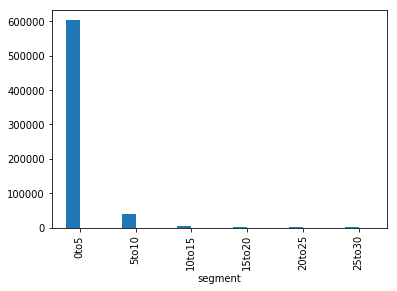

In [22]:
import matplotlib.pyplot as plt

difference_speed_df = pd.DataFrame(difference_speed)

# to make percetages x divided by the number of rows in the dataset
f = lambda x: x/649694

#adding the column to the dataframe
difference_speed_df['percentage'] = difference_speed_df['total_count'].apply(f)

# output to notebook
%matplotlib inline

#the actual plot (I have had real trouble getting bokeh to run properly)
plot_difference_speed = difference_speed_df.plot(difference_speed_df['segment'], kind='bar', legend=None)

pd.set_option('precision', 4)
column_bucket = ['segment', 'percentage', 'total_count']
difference_speed_df[column_bucket]

from this we can gather that most of the difference lies in the smallest band range and thus both data streams validate each other. Thus we can use either OBD or GPS dataset to make a split in speed so we can get a ratio of ***local driving*** and ***highway driving***

This subdivision is what we do next

In [23]:
driving_area = []

#bigquery on 70 km/h
for vehicle in fleet:
    local_df = pd.read_gbq("select count (*) from [headingon_params.speed_obd] where value <= 70 and vehicle = '%s' " %vehicle ,projectid)
    highways_df = pd.read_gbq("select count (*) from [headingon_params.speed_obd] where value > 70 and vehicle = '%s' " %vehicle ,projectid)
    #appending them in a list
    driving_area.append({'vehicles': vehicle, 'highways': highways_df.iat[0,0], 'local': local_df.iat[0,0] })    


Requesting query... ok.
Job ID: job_5bPGyx1bqlG5MOC2UkX4tfmLnd0X
Query running...
Query done.
Cache hit.

Retrieving results...
Got 1 rows.

Total time taken 1.08 s.
Finished at 2017-10-13 12:05:27.
Requesting query... ok.
Job ID: job_DZ2SPXuGkVAW__yxA0ShU-_5rz1b
Query running...
Query done.
Cache hit.

Retrieving results...
Got 1 rows.

Total time taken 0.64 s.
Finished at 2017-10-13 12:05:29.
Requesting query... ok.
Job ID: job_63V40383UXS5sOFIPMxsHiRtyvSF
Query running...
Query done.
Cache hit.

Retrieving results...
Got 1 rows.

Total time taken 0.63 s.
Finished at 2017-10-13 12:05:31.
Requesting query... ok.
Job ID: job_ncLD2jS6wpIrs0oLqL5bVY39FIlx
Query running...
Query done.
Cache hit.

Retrieving results...
Got 1 rows.

Total time taken 0.74 s.
Finished at 2017-10-13 12:05:33.
Requesting query... ok.
Job ID: job_O2q2c-lwjPsgA6dXBEWyPHw0x6lF
Query running...
Query done.
Cache hit.

Retrieving results...
Got 1 rows.

Total time taken 0.76 s.
Finished at 2017-10-13 12:05:35.
Reque

In [24]:
#putting into a dataframe
driving_area_df = pd.DataFrame(driving_area)

#adding totals
driving_area_df['total'] = driving_area_df['highways'].add(driving_area_df['local'])

#adding percentages
driving_area_df['perc_highway'] = driving_area_df['highways'].div(driving_area_df['total'])
driving_area_df['perc_local'] = driving_area_df['local'].div(driving_area_df['total'])

#make the column sequence more readable
column_list_driving_area = ['vehicles', 'highways', 'local', 'perc_highway', 'perc_local']

#showing the data
driving_area_df[column_list_driving_area]

,vehicles,highways,local,perc_highway,perc_local
0,car1,13606,50223,0.2132,0.7868
1,car2,4600,9442,0.3276,0.6724
2,car3,19754,38607,0.3385,0.6615
3,car4,66522,182383,0.2673,0.7327
4,car5,24488,44394,0.3555,0.6445
5,car6,61940,43077,0.5898,0.4102
6,car7,50358,40788,0.5525,0.4475


## **conclusion driving areas**

We used the following parameter:

* gps_vs_obd_speed_difference

which compares the data of both the GPS and OBD speed data parameters to validate there accuracy. Which was sastisfactory 
acurate.

Then we took the OBD parameter, since this is already in the preffered units (km/h). And than we took an arbitrary speed point, 70 km/h, to distinguish in which areas the drives mostly where situated.

The result shows that *car6* and *car7* both drive more on the higways than the other cars. Which is an relevant discovery for the future.

## **Driving style:**
To test if driving style has an influence on the usage of a tire, I need to use some form of proxy. 
I have settled on the following:

- engine_RPM



I will first explore the data and validate it. 
With *obd_speed* specifically *car4* for a specific time *timestamp < 2016-10-04 12:40:00 UTC* Then I will device a way to make it relevantBut it will become a little more arbitrary to choose where the difference lies between 'normal' and 'aggressive' driving? Best I can come up with is take some sampling averages and use the highest average accelarators as 'aggressive' and scale back from there.

In [63]:
correlation_speed_and_acceleration = []


for vehicle in fleet:
    speed_df = pd.read_gbq("select timestamp, value from [headingon_params.speed_obd] where vehicle = '%s' "%vehicle, projectid)
    accelerator_df = pd.read_gbq("select timestamp, value from [headingon_params.accelerator_pedalposition_d]  where vehicle = '%s' "%vehicle, projectid)
    merged_df = pd.merge(accelerator_df, speed_df, on='timestamp', how='inner')
    correlation_speed_and_acceleration.append({'vehicles': vehicle, 'correlation_speed/acceleratio': accelerator_df['value'].corr(speed_df['value'])})

Requesting query... ok.
Job ID: job_6-mVWyTqCnJygQetA81t9n6xOOJ4
Query running...
Query done.
Cache hit.

Retrieving results...
Got 63829 rows.

Total time taken 3.52 s.
Finished at 2017-10-13 14:06:10.
Requesting query... ok.
Job ID: job_bKqw0jegbSHgv6xwiN2i0-pjQGq7
Query running...
Query done.
Cache hit.

Retrieving results...
Got 13553 rows.

Total time taken 1.37 s.
Finished at 2017-10-13 14:06:12.
Requesting query... ok.
Job ID: job_V7_a7WPruNOCnGFVIGpz3uE3wu7U
Query running...
Query done.
Cache hit.

Retrieving results...
Got 14042 rows.

Total time taken 1.52 s.
Finished at 2017-10-13 14:06:15.
Requesting query... ok.
Job ID: job_Rn7yKT4SjED0yldJKr5RaNoqPZrx
Query running...
Query done.
Cache hit.

Retrieving results...
Got 14020 rows.

Total time taken 1.58 s.
Finished at 2017-10-13 14:06:18.
Requesting query... ok.
Job ID: job_V_EC0voWlTA4Cd4bI4rWX0DuLAmy
Query running...
Query done.
Cache hit.

Retrieving results...
Got 58361 rows.

Total time taken 3.57 s.
Finished at 2017-1

In [64]:
pd.DataFrame(correlation_speed_and_acceleration)


,correlation_speed/acceleratio,vehicles
0,-0.0983,car1
1,0.5881,car2
2,0.5042,car3
3,0.2143,car4
4,0.2610,car5
5,NaN,car6
6,NaN,car7


Needless to say I did not expect such inconclusive results. This means that according to the data I cannot validated the data. 

Since my initial idea was to take the moment of 0 speed, eg standing still which could be several seconds and compare the acceleration of the first 5 seconds *after* the last total stop. 

By registering those timeframes we should see a pattern per car (assuming these are all the same driver) and how fast a car is accelerating from a full stop, by indexing these moments into buckets,  1 = really slow acceleration to 5 = really fast acceleration, we could use this in the regression model concerning the wearage of the tire.

However, since I cannot confidently use the acceloration parameter, I will focus in **Sprint2** on doing this with the parameter *speed_obd* which has already validated before. 